torch.Size([3, 4]) torch.Size([23, 3]) torch.Size([23, 1])
Mean Spectral Angle Mapper (Endmembers) after matching: 7.79 degrees
Mean Spectral Angle Mapper (Abundances) after matching: 9.61 degrees


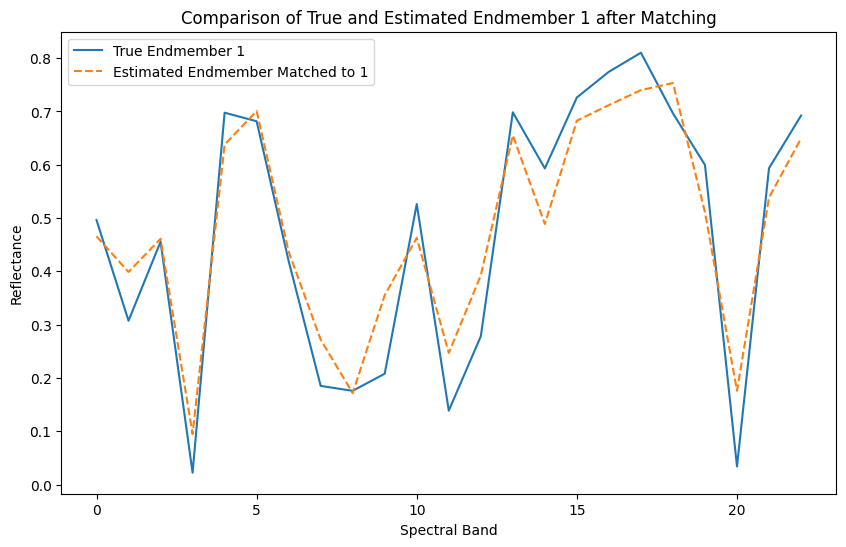

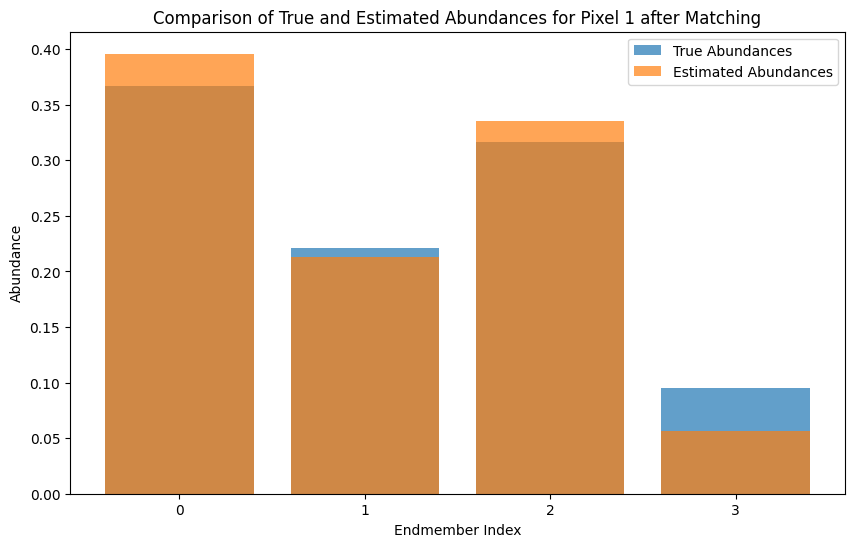

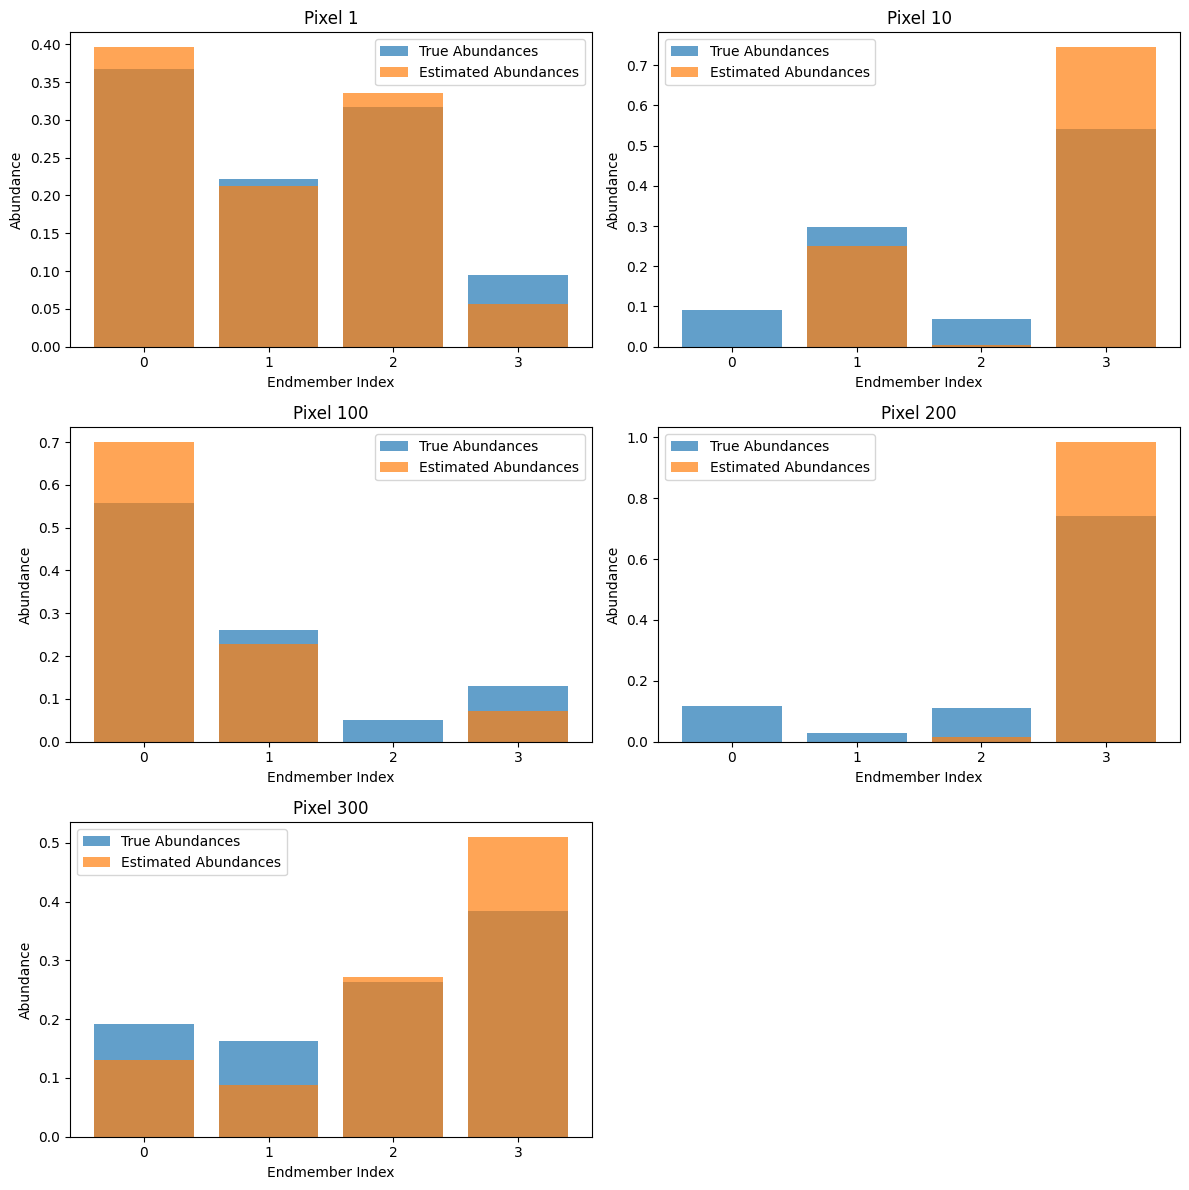

In [21]:
import torch
import numpy as np
from scipy.optimize import nnls, linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters
M = 23    # Number of spectral bands
N = 4     # Number of endmembers
L = 10000  # Number of pixels

# Generate random endmember signatures (A), each column is an endmember
A = torch.rand(M, N)

# Generate abundance vectors s[n], following a Dirichlet distribution to satisfy (A1) and (A2)
alpha = torch.ones(N)  # Dirichlet parameters
abundances = torch.distributions.Dirichlet(alpha).sample((L,)).t()

# Ensure abundances are non-negative and sum to one
assert torch.all(abundances >= 0)
assert torch.allclose(abundances.sum(dim=0), torch.ones(L))

# Generate observed pixel vectors x[n] = A * s[n]
X = torch.matmul(A, abundances)

# Compute the mean of the observed pixels
d = X.mean(dim=1, keepdim=True)

# Center the data
U = X - d  # Shape: (M, L)

# Compute the covariance matrix
covariance_matrix = U @ U.T / (L - 1)  # Shape: (M, M)

# Perform eigenvalue decomposition
eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
C = eigenvectors[:, sorted_indices[:N-1]]  # Shape: (M, N-1)

# Ensure that C is of full column rank
assert torch.linalg.matrix_rank(C) == N - 1

# Compute the pseudoinverse of C
C_pinv = torch.pinverse(C)  # Shape: (N-1, M)

# Project the data
X_tilde = C_pinv @ (X - d)  # Shape: (N-1, L)

# Project the endmembers
alpha_true = C_pinv @ (A - d)  # Shape: (N-1, N)

# Compute the convex hull
X_tilde_np = X_tilde.numpy().T  # Shape: (L, N-1)
hull = ConvexHull(X_tilde_np)

# Get the vertices of the convex hull as initial estimates of the projected endmembers
vertices = X_tilde_np[hull.vertices]

# If the number of vertices is greater than N, we need to select N vertices
if vertices.shape[0] > N:
    # Use k-means clustering to select N representative vertices
    kmeans = KMeans(n_clusters=N, random_state=0).fit(vertices)
    alpha_est = torch.from_numpy(kmeans.cluster_centers_.T)
else:
    alpha_est = torch.from_numpy(vertices[:N].T)

print(alpha_est.shape, C.shape, d.shape)

# Construct B matrix
B = alpha_est[:, :-1] - alpha_est[:, [-1]]  # Shape: (N-1, N-1)
B_inv = torch.inverse(B)
H = B_inv
g = B_inv @ alpha_est[:, -1]

# Estimate endmembers in original space
A_est = C @ alpha_est + d

# Ensure A_est is of shape (M, N)
assert A_est.shape == (M, N)

# Estimate abundances
s_est = torch.zeros(N, L)
A_est_np = A_est.numpy()

for n in range(L):
    x_n = X[:, n].numpy()
    s_n, _ = nnls(A_est_np, x_n)
    s_est[:, n] = torch.from_numpy(s_n)

# Normalize abundances to sum to one
sums = s_est.sum(dim=0)
s_est = s_est / sums

# Compute Spectral Angle Mapper (SAM)
def spectral_angle_mapper(a_true, a_est):
    num = torch.sum(a_true * a_est, dim=0)
    denom = torch.norm(a_true, dim=0) * torch.norm(a_est, dim=0)
    angle = torch.acos(torch.clamp(num / denom, -1.0, 1.0))
    return angle

# Compute the cost matrix (Spectral Angle in radians)
cost_matrix = torch.zeros(N, N)
for i in range(N):
    for j in range(N):
        num = torch.dot(A[:, i], A_est[:, j])
        denom = torch.norm(A[:, i]) * torch.norm(A_est[:, j])
        angle = torch.acos(torch.clamp(num / denom, -1.0, 1.0))
        cost_matrix[i, j] = angle.item()

# Convert cost_matrix to NumPy array for linear_sum_assignment
cost_matrix_np = cost_matrix.numpy()

# Apply the Hungarian Algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix_np)

# Reorder the estimated endmembers and abundances
A_est_matched = A_est[:, col_ind]
s_est_matched = s_est[col_ind, :]

# Now compute the SAM between matched pairs
sam_endmembers = spectral_angle_mapper(A, A_est_matched)
mean_sam_endmembers = torch.mean(sam_endmembers)

print(f"Mean Spectral Angle Mapper (Endmembers) after matching: {mean_sam_endmembers.item() * 180 / np.pi:.2f} degrees")

# Compute SAM for abundances
sam_abundances = spectral_angle_mapper(abundances, s_est_matched)
mean_sam_abundances = torch.mean(sam_abundances)

print(f"Mean Spectral Angle Mapper (Abundances) after matching: {mean_sam_abundances.item() * 180 / np.pi:.2f} degrees")

pixel_id = 0
# Plot true vs estimated endmembers for the first matched endmember
plt.figure(figsize=(10, 6))
plt.plot(A[:, pixel_id].numpy(), label='True Endmember 1')
plt.plot(A_est_matched[:, pixel_id].detach().numpy(), '--', label='Estimated Endmember Matched to 1')
plt.legend()
plt.title('Comparison of True and Estimated Endmember 1 after Matching')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.show()

# Plot abundances for the first pixel
plt.figure(figsize=(10, 6))
plt.bar(range(N), abundances[:, pixel_id].numpy(), alpha=0.7, label='True Abundances')
plt.bar(range(N), s_est_matched[:, pixel_id].numpy(), alpha=0.7, label='Estimated Abundances')
plt.xticks(range(N))
plt.legend()
plt.title('Comparison of True and Estimated Abundances for Pixel 1 after Matching')
plt.xlabel('Endmember Index')
plt.ylabel('Abundance')
plt.show()

def plot_multiple_abundances(pixel_indices):
    """
    Plots the true and estimated abundances for multiple pixel indices in a grid.

    Parameters:
    pixel_indices (list of int): A list of pixel indices to plot.
    """
    num_pixels = len(pixel_indices)
    cols = 2  # Number of columns in the grid
    rows = (num_pixels + 1) // cols  # Calculate the number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axs = axs.flatten()

    for i, pixel_index in enumerate(pixel_indices):
        if pixel_index < 0 or pixel_index >= L:
            print(f"Pixel index {pixel_index} is out of bounds.")
            continue

        axs[i].bar(range(N), abundances[:, pixel_index].numpy(), alpha=0.7, label='True Abundances')
        axs[i].bar(range(N), s_est_matched[:, pixel_index].numpy(), alpha=0.7, label='Estimated Abundances')
        axs[i].set_xticks(range(N))
        axs[i].set_title(f'Pixel {pixel_index + 1}')
        axs[i].set_xlabel('Endmember Index')
        axs[i].set_ylabel('Abundance')
        axs[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# Example usage
pixel_indices = [0, 9, 99, 199, 299]
plot_multiple_abundances(pixel_indices)

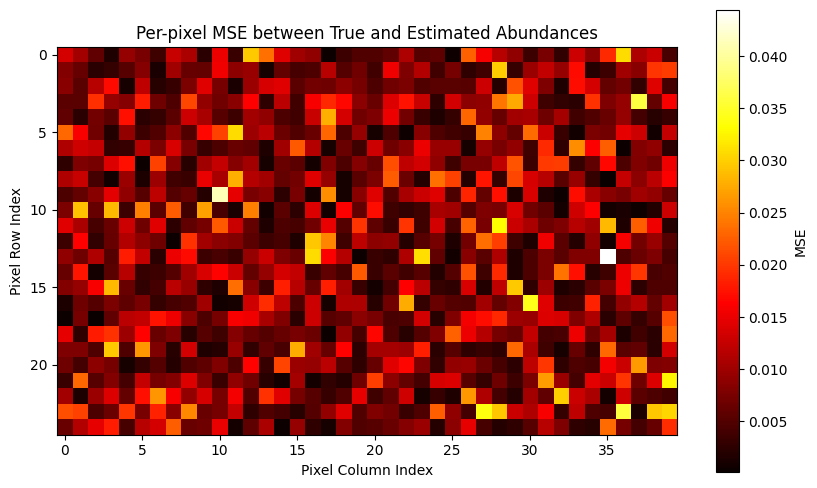

In [17]:
import torch
import numpy as np
from scipy.optimize import nnls, linear_sum_assignment
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Parameters
M = 20    # Number of spectral bands
N = 4     # Number of endmembers
L = 1000  # Number of pixels

# Generate random endmember signatures (A)
A = torch.rand(M, N)

# Generate abundance vectors s[n]
alpha = torch.ones(N)  # Dirichlet parameters
abundances = torch.distributions.Dirichlet(alpha).sample((L,)).t()

# Generate observed pixel vectors x[n] = A * s[n]
X = torch.matmul(A, abundances)

# Compute the mean of the observed pixels
d = X.mean(dim=1, keepdim=True)

# Center the data
U = X - d  # Shape: (M, L)

# Compute the covariance matrix
covariance_matrix = U @ U.T / (L - 1)  # Shape: (M, M)

# Perform eigenvalue decomposition
eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
C = eigenvectors[:, sorted_indices[:N-1]]  # Shape: (M, N-1)

# Compute the pseudoinverse of C
C_pinv = torch.pinverse(C)  # Shape: (N-1, M)

# Project the data
X_tilde = C_pinv @ (X - d)  # Shape: (N-1, L)

# Compute the convex hull
X_tilde_np = X_tilde.numpy().T  # Shape: (L, N-1)
hull = ConvexHull(X_tilde_np)

# Get the vertices of the convex hull
vertices = X_tilde_np[hull.vertices]

# Select N vertices
if vertices.shape[0] > N:
    kmeans = KMeans(n_clusters=N, random_state=0).fit(vertices)
    alpha_est = torch.from_numpy(kmeans.cluster_centers_.T)
else:
    alpha_est = torch.from_numpy(vertices[:N].T)

# Construct B matrix
B = alpha_est[:, :-1] - alpha_est[:, [-1]]  # Shape: (N-1, N-1)
B_inv = torch.inverse(B)
H = B_inv
g = B_inv @ alpha_est[:, -1]

# Estimate endmembers in original space
A_est = C @ alpha_est + d

# Estimate abundances
s_est = torch.zeros(N, L)
A_est_np = A_est.numpy()

for n in range(L):
    x_n = X[:, n].numpy()
    s_n, _ = nnls(A_est_np, x_n)
    s_est[:, n] = torch.from_numpy(s_n)

# Normalize abundances
sums = s_est.sum(dim=0)
s_est = s_est / sums

# Compute the cost matrix
cost_matrix = torch.zeros(N, N)
for i in range(N):
    for j in range(N):
        num = torch.dot(A[:, i], A_est[:, j])
        denom = torch.norm(A[:, i]) * torch.norm(A_est[:, j])
        angle = torch.acos(torch.clamp(num / denom, -1.0, 1.0))
        cost_matrix[i, j] = angle.item()

# Apply the Hungarian Algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix.numpy())

# Reorder the estimated endmembers and abundances
A_est_matched = A_est[:, col_ind]
s_est_matched = s_est[col_ind, :]

# Compute per-pixel MSE
mse_per_pixel = torch.mean((abundances - s_est_matched) ** 2, dim=0)  # Shape: (L,)

# Define grid dimensions (rows x cols = L)
rows = 25
cols = 40

# Reshape the mse_per_pixel into a 2D array
mse_image = mse_per_pixel.reshape(rows, cols)

# Plot the MSE image
plt.figure(figsize=(10, 6))
plt.imshow(mse_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='MSE')
plt.title('Per-pixel MSE between True and Estimated Abundances')
plt.xlabel('Pixel Column Index')
plt.ylabel('Pixel Row Index')
plt.show()